In [3]:
import ast
import numpy as np
import matplotlib.pyplot as plt
from patsy import dmatrix
import pandas as pd
import tensorflow as tf
import os
import re
from matplotlib.patches import Patch
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

# Ground-truth nonlinear effect functions (assumed to be defined elsewhere in your code)
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def read_with_var_name(var_name, var_type, save_path, scenario_index):
    if var_type == 'npy':
        return np.load(f"{save_path}/{var_name}_{scenario_index}.npy")
    if var_type == 'keras':
        return tf.keras.models.load_model(f"{save_path}/{var_name}_{scenario_index}.keras")
    if var_type == 'df':
        return pd.read_csv(f"{save_path}/{var_name}_{scenario_index}.csv")

def transform_param_eta(eta_str):
    """
    Transforms an R-style spline term like:
      s(Z1, k = 15, bs = "cr")
    into a Python-style term:
      spline(Z1, bs='bs', df=14)
    Assumes that df = k - 1.
    Also transforms "(Intercept)" to "Intercept".
    """
    # Replace "(Intercept)" with "Intercept"
    eta_str = eta_str.replace("(Intercept)", "Intercept")
    
    pattern = r"s\((Z\d),\s*k\s*=\s*(\d+),\s*bs\s*=\s*['\"]cr['\"]\)"
    match = re.match(pattern, eta_str)
    if match:
        var = match.group(1)
        k_val = int(match.group(2))
        df_val = k_val - 1
        return f"spline({var}, bs='bs', df={df_val})"
    else:
        # Return the original string if it doesn't match the pattern.
        return eta_str

def convert_r_value_string(value_str):
    """
    Converts an R-style value string like:
      "c(-0.957615792751312)"
    or
      "c(0.00564139103516936, 0.0298147071152925, ...)"
    into a Python-style list string "[...]" so that it can be parsed.
    """
    value_str = value_str.strip()
    
    if value_str.startswith("c(") and value_str.endswith(")"):
        # Remove the leading "c(" and trailing ")"
        inner = value_str[2:-1].strip()
        # Replace commas with spaces so np.fromstring can parse it correctly.
        inner = inner.replace(",", " ")
        return f"[{inner}]"
    else:
        return value_str


2025-03-03 10:27:39.331393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 10:27:39.619830: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def derive_true_coefficients(X, true_linear_effects):
    """
    Derives the effective "true" coefficients from stored scaled covariates X and the
    true linear effects.

    Parameters
    ----------
    X : numpy.ndarray, shape (I, n_samples)
        The scaled covariates, where I is the number of features (e.g. 2 for X1 and X2).
    true_linear_effects : numpy.ndarray, shape (I, n_samples, K)
        The true linear effects for each structured covariate and each parameter group.
        Here, K is the number of parameter groups (e.g., for 'loc' and 'scale').
        The overall true effect for parameter group k for a given sample is computed as:
            eta_{j,k} = sum_{i=1}^{I} true_linear_effects[i, j, k].

    Returns
    -------
    beta : numpy.ndarray, shape (K, I)
        For each parameter group k, returns the estimated coefficients beta_{k} 
        (as obtained via least squares) so that for each sample j:
            eta_{j,k} ≈ X[:, j]^T beta_{k}.
    """
    # Transpose X to shape (n_samples, I)
    X_t = X.T  # shape (n_samples, I)
    
    # Sum over the feature dimension (axis=0) in true_linear_effects to obtain overall effects.
    # This yields an array of shape (n_samples, K)
    overall_effect = np.sum(true_linear_effects, axis=0)
    
    n_samples, K = overall_effect.shape
    I = X.shape[0]
    beta = np.zeros((K, I))
    
    # For each parameter group k, solve the least-squares problem:
    # X_t @ beta_k ≈ overall_effect[:, k]
    for k in range(K):
        y_k = overall_effect[:, k]  # shape (n_samples,)
        beta_k, residuals, rank, s = np.linalg.lstsq(X_t, y_k, rcond=None)
        beta[k, :] = beta_k  # beta_k has shape (I,)
    
    return beta

# # Example usage:
# # Suppose X is of shape (2, 100) and true_linear_effects is of shape (2, 100, 2):
# I = 2
# n_samples = 100
# K = 2
# # For demonstration, generate dummy data:
# X = read_with_var_name('X', 'npy', read_path, scenario_index)  # scaled covariates in [0,1]
# # Suppose the true coefficients (scaled) are:

# # Compute the true linear effects for each sample and each group:
# # For each group k, effect = sum_i beta[k, i] * X[i, :]
# true_linear_effects = read_with_var_name('linear_effects', 'npy', read_path, scenario_index)


# # Now derive the coefficients from the stored data:
# beta_est = derive_true_coefficients(X, true_linear_effects)
# print("Derived true coefficients (each row is a parameter group):")
# print(beta_est)


In [22]:
def plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                          python_estimate_path, r_estimate_path, combined=True, bias_reconstruct=False):
    """
    Plots the estimated spline curves for Z1 and Z2.
    
    If combined=True (default), both Python (blue) and R (red) curves are overlaid
    in a single figure with two subplots (one for Z1, one for Z2).
    
    If combined=False, two separate figures are generated:
      - One for Python results (Z1 and Z2 subplots in blue)
      - One for R results (Z1 and Z2 subplots in red)
    
    Note: Before plotting, each estimated spline is centered (i.e. its mean is subtracted)
          and the true nonlinear effects are similarly centered.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from patsy import dmatrix
    import os

    z1_grid = np.linspace(0, 1, 100)
    z2_grid = np.linspace(0, 1, 100)
    
    # Combined mode: one figure with two subplots
    if combined:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        for rep in range(n_reps):
            scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            
            # Python estimates (blue)
            try:
                coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            except FileNotFoundError:
                print(f"Python file not found for {scenario_index}.")
                coeff_dict_py = None
            
            if coeff_dict_py is not None:
                # For Z1
                term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
                df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
                if not df_Z1_py.empty:
                    coeff_str = df_Z1_py['value'].iloc[0]
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                                {"x": z1_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z1_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    # Center the estimated spline by subtracting its mean:
                    f_est = f_est - np.mean(f_est)
                    axes[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                                 zorder=1, label="Python" if rep == 0 else "")
                # For Z2
                term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
                df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
                if not df_Z2_py.empty:
                    coeff_str = df_Z2_py['value'].iloc[0]
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                                {"x": z2_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z2_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    # Center the estimated spline:
                    f_est = f_est - np.mean(f_est)
                    axes[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
                                 zorder=1, label="Python" if rep == 0 else "")
            
            # R estimates (red)
            try:
                coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
                coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
            except FileNotFoundError:
                print(f"R file not found for {scenario_index}.")
                coeff_dict_r = None
            
            if coeff_dict_r is not None:
                # For Z1
                term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
                df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
                if not df_Z1_r.empty:
                    coeff_str = df_Z1_r['value'].iloc[0]
                    coeff_str = convert_r_value_string(coeff_str)
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                                {"x": z1_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z1_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    # Center the estimated spline:
                    f_est = f_est - np.mean(f_est)
                    axes[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
                                 zorder=1, label="R" if rep == 0 else "")
                # For Z2
                term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
                df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
                if not df_Z2_r.empty:
                    coeff_str = df_Z2_r['value'].iloc[0]
                    coeff_str = convert_r_value_string(coeff_str)
                    estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                    if bias_reconstruct:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                                {"x": z2_grid}, return_type='dataframe')
                    else:
                        spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                                {"x": z2_grid}, return_type='dataframe')
                        if 'Intercept' in spline_basis.columns:
                            spline_basis = spline_basis.drop('Intercept', axis=1)
                    B = spline_basis.to_numpy()
                    f_est = B.dot(estimated_coeffs)
                    # Center the estimated spline:
                    f_est = f_est - np.mean(f_est)
                    axes[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
                                 zorder=1, label="R" if rep == 0 else "")
        
        # Overlay true nonlinear effects (black)
        true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
        true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
        # Center the true effects:
        true_effect_Z1 = true_effect_Z1 - np.mean(true_effect_Z1)
        true_effect_Z2 = true_effect_Z2 - np.mean(true_effect_Z2)
        axes[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
        axes[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
        axes[0].set_xlabel(r'$Z_1$')
        axes[0].set_ylabel(r'$f_1(Z_1)$')
        axes[0].set_title("Estimated Splines for Z1")
        axes[0].legend()
        axes[1].set_xlabel(r'$Z_2$')
        axes[1].set_ylabel(r'$f_2(Z_2)$')
        axes[1].set_title("Estimated Splines for Z2")
        axes[1].legend()
        plt.tight_layout()
        combined_filename = os.path.join(python_estimate_path, "combined_estimated_splines.png")
        plt.savefig(combined_filename)
        plt.show()
        print(f"Combined figure saved as {combined_filename}")
    
    else:
        # Separate mode: two figures, one for Python and one for R
        # Python figure
        fig_py, axes_py = plt.subplots(1, 2, figsize=(14, 6))
        for rep in range(n_reps):
            scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            try:
                coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            except FileNotFoundError:
                print(f"Python file not found for {scenario_index}.")
                continue
            # Z1
            term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
            df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
            if not df_Z1_py.empty:
                coeff_str = df_Z1_py['value'].iloc[0]
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                            {"x": z1_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z1_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                # Center the estimated spline:
                f_est = f_est - np.mean(f_est)
                axes_py[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
                                zorder=1)
            # Z2
            term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
            df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
            if not df_Z2_py.empty:
                coeff_str = df_Z2_py['value'].iloc[0]
                estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
                if bias_reconstruct:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
                                            {"x": z2_grid}, return_type='dataframe')
                else:
                    spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
                                            {"x": z2_grid}, return_type='dataframe')
                    if 'Intercept' in spline_basis.columns:
                        spline_basis = spline_basis.drop('Intercept', axis=1)
                B = spline_basis.to_numpy()
                f_est = B.dot(estimated_coeffs)
                # Center the estimated spline:
                f_est = f_est - np.mean(f_est)
                axes_py[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
                                zorder=1)
        # Overlay true effects
        true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
        true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
        true_effect_Z1 = true_effect_Z1 - np.mean(true_effect_Z1)
        true_effect_Z2 = true_effect_Z2 - np.mean(true_effect_Z2)
        axes_py[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
        axes_py[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
        axes_py[0].set_xlabel(r'$Z_1$')
        axes_py[0].set_ylabel(r'$f_1(Z_1)$')
        axes_py[0].set_title("Python: Estimated Splines for Z1")
        axes_py[0].legend()
        axes_py[1].set_xlabel(r'$Z_2$')
        axes_py[1].set_ylabel(r'$f_2(Z_2)$')
        axes_py[1].set_title("Python: Estimated Splines for Z2")
        axes_py[1].legend()


In [ ]:
# def plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
#                           python_estimate_path, r_estimate_path, combined=True, bias_reconstruct=False):
#     """
#     Plots the estimated spline curves for Z1 and Z2.
    
#     If combined=True (default), both Python (blue) and R (red) curves are overlaid
#     in a single figure with two subplots (one for Z1, one for Z2).
    
#     If combined=False, two separate figures are generated:
#       - One for Python results (Z1 and Z2 subplots in blue)
#       - One for R results (Z1 and Z2 subplots in red)
#     """
#     z1_grid = np.linspace(0, 1, 100)
#     z2_grid = np.linspace(0, 1, 100)
    
#     # Combined mode: one figure with two subplots
#     if combined:
#         fig, axes = plt.subplots(1, 2, figsize=(14, 6))
#         for rep in range(n_reps):
#             scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
            
#             # Python estimates (blue)
#             try:
#                 coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
#             except FileNotFoundError:
#                 print(f"Python file not found for {scenario_index}.")
#                 coeff_dict_py = None
            
#             if coeff_dict_py is not None:
#                 # For Z1
#                 term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
#                 df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
#                 if not df_Z1_py.empty:
#                     coeff_str = df_Z1_py['value'].iloc[0]
#                     estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                     if bias_reconstruct:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                                 {"x": z1_grid}, return_type='dataframe')
#                     else:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                                 {"x": z1_grid}, return_type='dataframe')
#                         if 'Intercept' in spline_basis.columns:
#                             spline_basis = spline_basis.drop('Intercept', axis=1)
#                     B = spline_basis.to_numpy()
#                     f_est = B.dot(estimated_coeffs)
#                     axes[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
#                                  zorder=1, label="Python" if rep == 0 else "")
#                 # For Z2
#                 term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
#                 df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
#                 if not df_Z2_py.empty:
#                     coeff_str = df_Z2_py['value'].iloc[0]
#                     estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                     if bias_reconstruct:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                             {"x": z2_grid}, return_type='dataframe')
#                     else:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                                 {"x": z2_grid}, return_type='dataframe')
#                         if 'Intercept' in spline_basis.columns:
#                             spline_basis = spline_basis.drop('Intercept', axis=1)
#                     B = spline_basis.to_numpy()
#                     f_est = B.dot(estimated_coeffs)
#                     axes[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
#                                  zorder=1, label="Python" if rep == 0 else "")
            
#             # R estimates (red)
#             try:
#                 coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
#                 coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)

#             except FileNotFoundError:
#                 print(f"R file not found for {scenario_index}.")
#                 coeff_dict_r = None
            
#             if coeff_dict_r is not None:
#                 # For Z1
#                 term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
#                 df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
#                 if not df_Z1_r.empty:
#                     coeff_str = df_Z1_r['value'].iloc[0]
#                     coeff_str = convert_r_value_string(coeff_str)
#                     estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                     if bias_reconstruct:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                             {"x": z1_grid}, return_type='dataframe')
#                     else:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                                 {"x": z1_grid}, return_type='dataframe')
#                         if 'Intercept' in spline_basis.columns:
#                             spline_basis = spline_basis.drop('Intercept', axis=1)
#                     B = spline_basis.to_numpy()
#                     f_est = B.dot(estimated_coeffs)
#                     axes[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
#                                  zorder=1, label="R" if rep == 0 else "")
#                 # For Z2
#                 term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
#                 df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
#                 if not df_Z2_r.empty:
#                     coeff_str = df_Z2_r['value'].iloc[0]
#                     coeff_str = convert_r_value_string(coeff_str)
#                     estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                     if bias_reconstruct:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                             {"x": z2_grid}, return_type='dataframe')
#                     else:
#                         spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                                 {"x": z2_grid}, return_type='dataframe')
#                         if 'Intercept' in spline_basis.columns:
#                             spline_basis = spline_basis.drop('Intercept', axis=1)
#                     B = spline_basis.to_numpy()
#                     f_est = B.dot(estimated_coeffs)
#                     axes[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
#                                  zorder=1, label="R" if rep == 0 else "")
        
#         # Overlay true nonlinear effects (black)
#         true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
#         true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
#         axes[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
#         axes[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
#         axes[0].set_xlabel(r'$Z_1$')
#         axes[0].set_ylabel(r'$f_1(Z_1)$')
#         axes[0].set_title("Estimated Splines for Z1")
#         axes[0].legend()
#         axes[1].set_xlabel(r'$Z_2$')
#         axes[1].set_ylabel(r'$f_2(Z_2)$')
#         axes[1].set_title("Estimated Splines for Z2")
#         axes[1].legend()
#         plt.tight_layout()
#         combined_filename = os.path.join(python_estimate_path, "combined_estimated_splines.png")
#         plt.savefig(combined_filename)
#         plt.show()
#         print(f"Combined figure saved as {combined_filename}")
    
#     else:
#         # Separate mode: two figures, one for Python and one for R
#         # Python figure
#         fig_py, axes_py = plt.subplots(1, 2, figsize=(14, 6))
#         for rep in range(n_reps):
#             scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
#             try:
#                 coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
#             except FileNotFoundError:
#                 print(f"Python file not found for {scenario_index}.")
#                 continue
#             # Z1
#             term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
#             df_Z1_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z1]
#             if not df_Z1_py.empty:
#                 coeff_str = df_Z1_py['value'].iloc[0]
#                 estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                 if bias_reconstruct:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                         {"x": z1_grid}, return_type='dataframe')
#                 else:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                             {"x": z1_grid}, return_type='dataframe')
#                     if 'Intercept' in spline_basis.columns:
#                         spline_basis = spline_basis.drop('Intercept', axis=1)
#                 B = spline_basis.to_numpy()
#                 f_est = B.dot(estimated_coeffs)
#                 axes_py[0].plot(z1_grid, f_est, color='blue', alpha=0.2, lw=1,
#                                 zorder=1)
#             # Z2
#             term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
#             df_Z2_py = coeff_dict_py[coeff_dict_py['param_eta'] == term_Z2]
#             if not df_Z2_py.empty:
#                 coeff_str = df_Z2_py['value'].iloc[0]
#                 estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                 if bias_reconstruct:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                     {"x": z2_grid}, return_type='dataframe')
#                 else:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                             {"x": z2_grid}, return_type='dataframe')
#                     if 'Intercept' in spline_basis.columns:
#                         spline_basis = spline_basis.drop('Intercept', axis=1)
#                 B = spline_basis.to_numpy()
#                 f_est = B.dot(estimated_coeffs)
#                 axes_py[1].plot(z2_grid, f_est, color='blue', alpha=0.2, lw=1,
#                                 zorder=1)
#         # Overlay true effects
#         true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
#         true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
#         axes_py[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
#         axes_py[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
#         axes_py[0].set_xlabel(r'$Z_1$')
#         axes_py[0].set_ylabel(r'$f_1(Z_1)$')
#         axes_py[0].set_title("Python: Estimated Splines for Z1")
#         axes_py[0].legend()
#         axes_py[1].set_xlabel(r'$Z_2$')
#         axes_py[1].set_ylabel(r'$f_2(Z_2)$')
#         axes_py[1].set_title("Python: Estimated Splines for Z2")
#         axes_py[1].legend()
#         plt.tight_layout()
#         py_filename = os.path.join(python_estimate_path, "python_estimated_splines.png")
#         plt.savefig(py_filename)
#         plt.show()
#         print(f"Python-only figure saved as {py_filename}")
        
#         # R figure
#         fig_r, axes_r = plt.subplots(1, 2, figsize=(14, 6))
#         for rep in range(n_reps):
#             scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
#             try:
#                 coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
#                 coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
#             except FileNotFoundError:
#                 print(f"R file not found for {scenario_index}.")
#                 continue
#             # Z1
#             term_Z1 = f"spline(Z1, bs='bs', df={n_knots+4})"
#             df_Z1_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z1]
#             if not df_Z1_r.empty:
#                 coeff_str = df_Z1_r['value'].iloc[0]
#                 coeff_str = convert_r_value_string(coeff_str)
#                 estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                 if bias_reconstruct:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                         {"x": z1_grid}, return_type='dataframe')
#                 else:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                             {"x": z1_grid}, return_type='dataframe')
#                     if 'Intercept' in spline_basis.columns:
#                         spline_basis = spline_basis.drop('Intercept', axis=1)
#                 B = spline_basis.to_numpy()
#                 f_est = B.dot(estimated_coeffs)
#                 axes_r[0].plot(z1_grid, f_est, color='red', alpha=0.2, lw=1,
#                                zorder=1)
#             # Z2
#             term_Z2 = f"spline(Z2, bs='bs', df={n_knots+4})"
#             df_Z2_r = coeff_dict_r[coeff_dict_r['param_eta'] == term_Z2]
#             if not df_Z2_r.empty:
#                 coeff_str = df_Z2_r['value'].iloc[0]
#                 coeff_str = convert_r_value_string(coeff_str)
#                 estimated_coeffs = np.fromstring(coeff_str.strip("[]"), sep=" ")
#                 if bias_reconstruct:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+3}, include_intercept=True)",
#                                         {"x": z2_grid}, return_type='dataframe')
#                 else:
#                     spline_basis = dmatrix(f"bs(x, df={n_knots+4}, include_intercept=False)",
#                                             {"x": z2_grid}, return_type='dataframe')
#                     if 'Intercept' in spline_basis.columns:
#                         spline_basis = spline_basis.drop('Intercept', axis=1)
#                 B = spline_basis.to_numpy()
#                 f_est = B.dot(estimated_coeffs)
#                 axes_r[1].plot(z2_grid, f_est, color='red', alpha=0.2, lw=1,
#                                zorder=1)
#         # Overlay true effects
#         true_effect_Z1 = nonlinear_effect_1_z1(z1_grid)
#         true_effect_Z2 = nonlinear_effect_1_z2(z2_grid)
#         axes_r[0].plot(z1_grid, true_effect_Z1, color='black', lw=3, label='True Effect', zorder=100)
#         axes_r[1].plot(z2_grid, true_effect_Z2, color='black', lw=3, label='True Effect', zorder=100)
#         axes_r[0].set_xlabel(r'$Z_1$')
#         axes_r[0].set_ylabel(r'$f_1(Z_1)$')
#         axes_r[0].set_title("R: Estimated Splines for Z1")
#         axes_r[0].legend()
#         axes_r[1].set_xlabel(r'$Z_2$')
#         axes_r[1].set_ylabel(r'$f_2(Z_2)$')
#         axes_r[1].set_title("R: Estimated Splines for Z2")
#         axes_r[1].legend()
#         plt.tight_layout()
#         r_filename = os.path.join(python_estimate_path, "r_estimated_splines.png")
#         plt.savefig(r_filename)
#         plt.show()
#         print(f"R-only figure saved as {r_filename}")


In [ ]:
def plot_linear_boxplots(n, n_reps, d, snr, method,
                         python_estimate_path, r_estimate_path, true_path):
    """
    Reads Python estimates, R estimates, and true values (if any),
    and plots them as grouped boxplots for each parameter (e.g. 'loc', 'scale', etc.).

    - If Python or R data for a term is missing, that box is skipped.
    - If the True data for a term has only 1 value, we skip plotting that box (to avoid single-point boxes).
    - Each term is placed at one x-axis group location, with Python, R, and possibly True boxes side by side.

    Modified so that any estimate with length > 1 (e.g., spline coefficients) is skipped.
    """

    # Containers for estimated coefficients
    results_py = {}
    results_r = {}
    true_values = {}

    # -------------------------------------------------------------------------
    # 1) Read estimates and true values over all replicates
    # -------------------------------------------------------------------------
    for rep in range(n_reps):
        scenario_index = f"n_{n}_rep_{rep}_dist_{d}_SNR_{snr}_{method}"
        scenario_X = f"n_{n}_rep_{rep}"

        # ------------------ Read Python estimates ------------------
        try:
            coeff_dict_py = read_with_var_name('point_estimates', 'df', python_estimate_path, scenario_index)
            param_types_py = coeff_dict_py['param_y'].unique()
            param_eta_values_py = coeff_dict_py['param_eta'].unique()
        except FileNotFoundError:
            print(f"Python file not found for {scenario_index}. Skipping replicate.")
            continue

        # Dynamically initialize/update results_py
        for param in param_types_py:
            if param not in results_py:
                results_py[param] = {term: [] for term in param_eta_values_py}
            else:
                # Add new terms if they appear
                for term in param_eta_values_py:
                    if term not in results_py[param]:
                        results_py[param][term] = []

            # Fill data (only if val.size == 1)
            for term in param_eta_values_py:
                df_term = coeff_dict_py[
                    (coeff_dict_py['param_y'] == param) &
                    (coeff_dict_py['param_eta'] == term)
                ]
                if not df_term.empty:
                    val = np.fromstring(df_term['value'].iloc[0].strip("[]"), sep=" ")
                    if val.size == 1:
                        # Only store single-valued coefficients
                        results_py[param][term].append(val[0])
                    # else:
                    #     # Spline or multi-value: skip
                    #     print(f"Skipping multi-value estimate (Python) for param={param}, term='{term}': {val}")

        # ------------------ Read R estimates ------------------
        try:
            coeff_dict_r = read_with_var_name('point_estimates', 'df', r_estimate_path, scenario_index)
            coeff_dict_r['param_eta'] = coeff_dict_r['param_eta'].apply(transform_param_eta)
            param_types_r = coeff_dict_r['param_y'].unique()
            param_eta_values_r = coeff_dict_r['param_eta'].unique()
        except FileNotFoundError:
            print(f"R file not found for {scenario_index}.")
            continue  # Skip this replicate if R data is missing

        # Dynamically initialize/update results_r
        for param in param_types_r:
            if param not in results_r:
                results_r[param] = {term: [] for term in param_eta_values_r}
            else:
                for term in param_eta_values_r:
                    if term not in results_r[param]:
                        results_r[param][term] = []

            # Fill data (only if val.size == 1)
            for term in param_eta_values_r:
                df_term = coeff_dict_r[
                    (coeff_dict_r['param_y'] == param) &
                    (coeff_dict_r['param_eta'] == term)
                ]
                if not df_term.empty:
                    raw_str = df_term['value'].iloc[0]
                    conv_str = convert_r_value_string(raw_str)
                    val = np.fromstring(conv_str.strip("[]"), sep=" ")
                    if val.size == 1:
                        results_r[param][term].append(val[0])
                    else:
                        # Spline or multi-value: skip
                        print(f"Skipping multi-value estimate (R) for param={param}, term='{term}': {val}")

        # ------------------ Read/derive True values ------------------
        try:
            X_struct = read_with_var_name('X', 'npy', true_path, scenario_X)
            true_lin_eff = read_with_var_name('linear_effects', 'npy', true_path, scenario_X)
            derived_beta = derive_true_coefficients(X_struct, true_lin_eff)
            
            # Suppose we only do something special if d == "gaussian_homo"
            for param in param_types_py:
                if param not in true_values:
                    true_values[param] = {term: [] for term in param_eta_values_py}
                if d == "gaussian_homo":
                    # Hard-coded example for 'loc' and 'scale'
                    if param == "loc":
                        # E.g. Intercept is 0, then derived_beta for X1, X2
                        true_values[param]['Intercept'].append(0)
                        true_values[param]['X1'].append(derived_beta[0, 0])
                        true_values[param]['X2'].append(derived_beta[0, 1])
                    elif param == "scale":
                        a_val = read_with_var_name('a', 'npy', true_path,
                                                   f"{scenario_X}_dist_{d}_SNR_{snr}")
                        true_values[param]['Intercept'].append(a_val)
        except Exception as e:
            print(f"Error deriving true coefficients for {scenario_index}: {e}")

    # -------------------------------------------------------------------------
    # 2) Plotting: group Python, R, and True side-by-side for each term
    # -------------------------------------------------------------------------
    params = list(results_py.keys())
    n_params = len(params)

    if n_params == 1:
        fig, axes = plt.subplots(figsize=(10, 6))
        axes = [axes]
    else:
        fig, axes = plt.subplots(n_params, 1, figsize=(10, 6 * n_params))

    for ax, param in zip(axes, params):
        term_keys = list(results_py[param].keys())  # All terms found for this param

        group_data = []      # boxplot data
        positions = []       # x positions for each box
        box_colors = []      # color for each box
        tick_positions = []  # center of each group
        tick_labels = []     # label for each group

        pos = 1.0  # starting x-position for the first group

        for term in term_keys:
            py_data = results_py.get(param, {}).get(term, [])
            r_data  = results_r.get(param, {}).get(term, [])
            t_data  = true_values.get(param, {}).get(term, [])

            # We'll gather all the data boxes for this term into a temporary list
            # so we can place them side-by-side in a group.
            term_group_data = []
            term_positions = []
            term_colors = []

            # Python box (if available)
            if len(py_data) > 0:
                term_group_data.append(py_data)
                term_positions.append(pos)
                term_colors.append('blue')
                pos += 0.6  # shift for next box

            # R box (if available)
            if len(r_data) > 0:
                term_group_data.append(r_data)
                term_positions.append(pos)
                term_colors.append('red')
                pos += 0.6

            # True box (if available AND length > 1)
            if len(t_data) > 1:
                term_group_data.append(t_data)
                term_positions.append(pos)
                term_colors.append('green')
                pos += 0.6
            elif len(t_data) == 1:
                # Skip plotting a single-point box
                print(f"Skipping single-value True box for {param}, term '{term}' -> {t_data}")

            # If we have at least one box for this term, finalize it
            if term_group_data:
                group_data.extend(term_group_data)
                positions.extend(term_positions)
                box_colors.extend(term_colors)
                
                # The group center is the mean of the positions we used
                group_center = np.mean(term_positions)
                tick_positions.append(group_center)
                tick_labels.append(term)

                # Add spacing before the next group
                pos += 1.0
            else:
                print(f"No data to plot for {param}, term '{term}'")

        if group_data:
            # Create the boxplot
            bp = ax.boxplot(group_data, positions=positions, patch_artist=True, widths=0.5)
            for patch, color in zip(bp['boxes'], box_colors):
                patch.set_facecolor(color)
                patch.set_alpha(0.6)

            # Set x-axis ticks to be at the group centers
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha="right")
            ax.set_title(f"{param.capitalize()} Coefficients")
            ax.set_ylabel("Coefficient Value")

            # Create a legend showing colors for Python, R, and True
            legend_handles = [
                Patch(facecolor='blue',  label='Python', alpha=0.6),
                Patch(facecolor='red',   label='R',       alpha=0.6),
                Patch(facecolor='green', label='True',    alpha=0.6)
            ]
            ax.legend(handles=legend_handles)
        else:
            ax.set_title(f"{param.capitalize()} Coefficients")
            ax.set_ylabel("Coefficient Value")
            ax.text(0.5, 0.5, f"No data to plot for '{param}'", 
                    transform=ax.transAxes, ha='center', va='center')

    plt.tight_layout()
    out_file = os.path.join(python_estimate_path, "linear_boxplots_generalized.png")
    plt.savefig(out_file)
    plt.show()
    print(f"Generalized boxplot figure saved as {out_file}")


In [30]:
# Parameters (adjust as needed)
n = 1000
n_reps = 100
d = "gaussian_homo"
snr = 8
n_knots = 6   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs_wo_unstructured/"
r_estimate_path = "../../SSDR/results/point_estimates_linear/"
true_path = "../data_generation/output_wo_unstructured"
# true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}




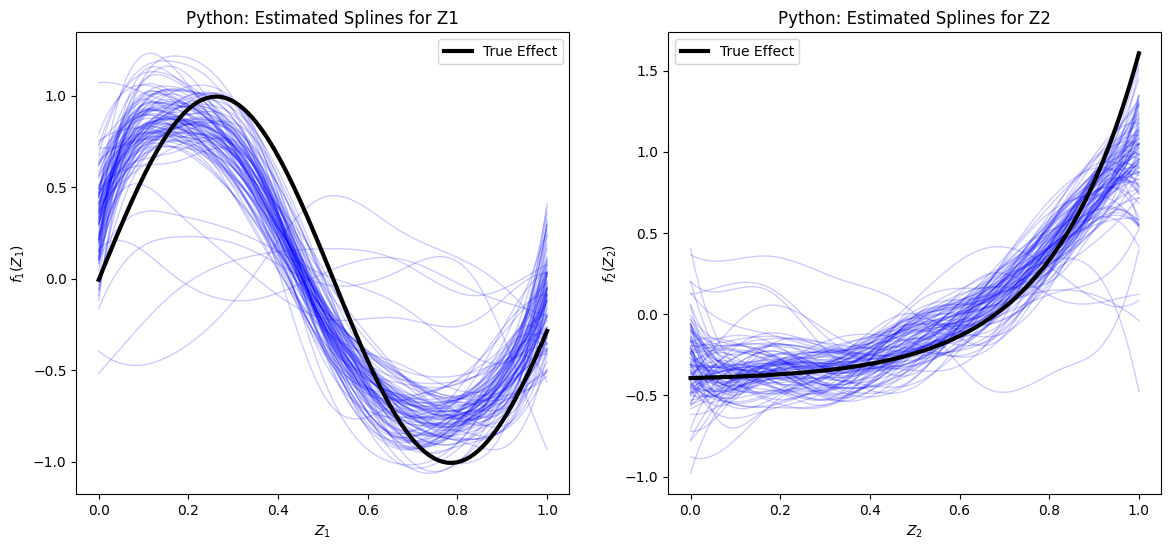

In [28]:
# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=True)


In [ ]:
# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=True)


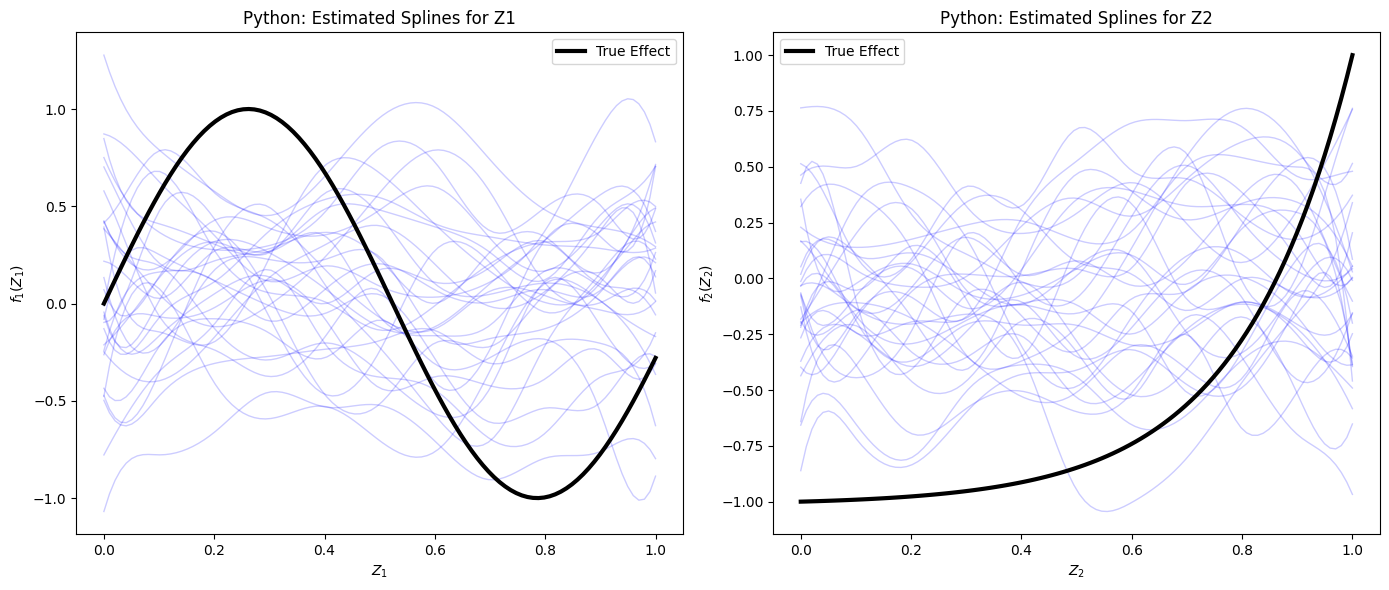

Python-only figure saved as ./outputs/python_estimated_splines.png


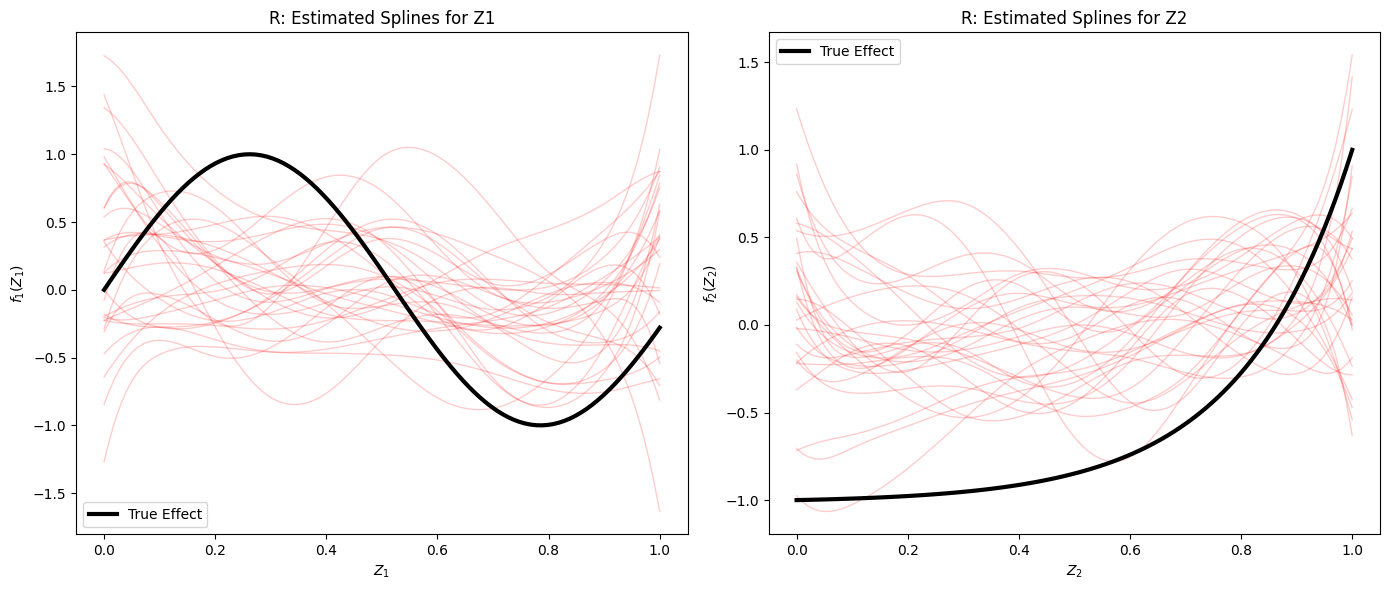

R-only figure saved as ./outputs/r_estimated_splines.png


In [22]:
# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=True)

In [23]:
# # Plot combined spline estimates
# plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
#                       python_estimate_path, r_estimate_path, combined=True)

In [24]:
# # Plot combined linear boxplots
# plot_linear_boxplots(n, n_reps, d, snr, method,
#                      python_estimate_path, r_estimate_path, true_path, true_linear, combined=False)


Skipping multi-value estimate (Python) for param=loc, term='spline(Z1, bs='bs', df=10)': [ 0.02938698  0.66496253  0.8812898   0.74900264  0.7840529  -0.24652421
 -0.74409825 -1.0160589  -0.5394615  -0.24029905]
Skipping multi-value estimate (Python) for param=loc, term='spline(Z2, bs='bs', df=10)': [-0.17343345 -0.33821705 -0.52008367 -0.11456056 -0.41821668 -0.1370309
  0.02136014  0.45135248  0.7806798   0.73438895]
Skipping multi-value estimate (Python) for param=loc, term='spline(Z1, bs='bs', df=10)': [ 0.4709279  -0.00763982 -0.08922736 -0.42627144  0.2211871   0.4905347
 -0.17187802  0.15354702  0.10789211 -0.3156697 ]
Skipping multi-value estimate (Python) for param=loc, term='spline(Z2, bs='bs', df=10)': [-0.25970066 -0.34138843 -0.49517816  0.13203213 -0.07452872 -0.11282408
  0.44610646  0.24831869  0.04408138 -0.08822954]
Skipping multi-value estimate (Python) for param=loc, term='spline(Z1, bs='bs', df=10)': [-0.36389315 -0.27055696 -0.05821011  0.24565911  0.32052773  0.4

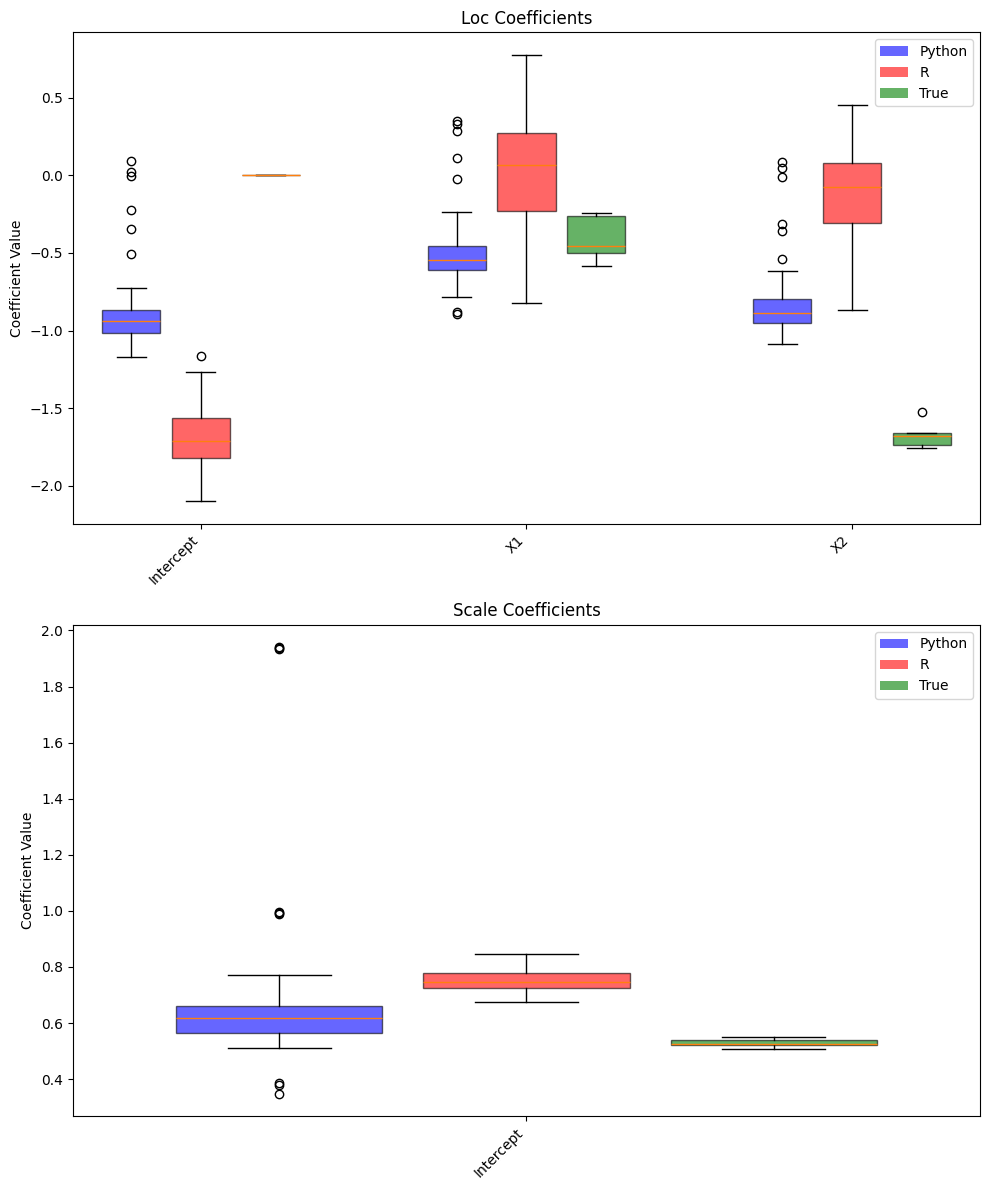

Generalized boxplot figure saved as ./outputs_wo_unstructured/linear_boxplots_generalized.png


In [35]:
# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path)


In [38]:
true_values

{'loc': {'Intercept': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'X1': [-0.2597168257496686,
   -0.45249808305909084,
   -0.5012384774000602,
   -0.24124650620249508,
   -0.5829106512792346,
   -0.6620040378199893,
   -0.7182555747132114,
   -0.7299660832253233,
   -0.7460933543394845,
   -0.5082825025524378,
   -0.2488273660246685,
   -0.4324394790309578,
   -0.7184118382720113,
   -0.6912435860390221,
   -0.6082926506208871,
   -0.44822

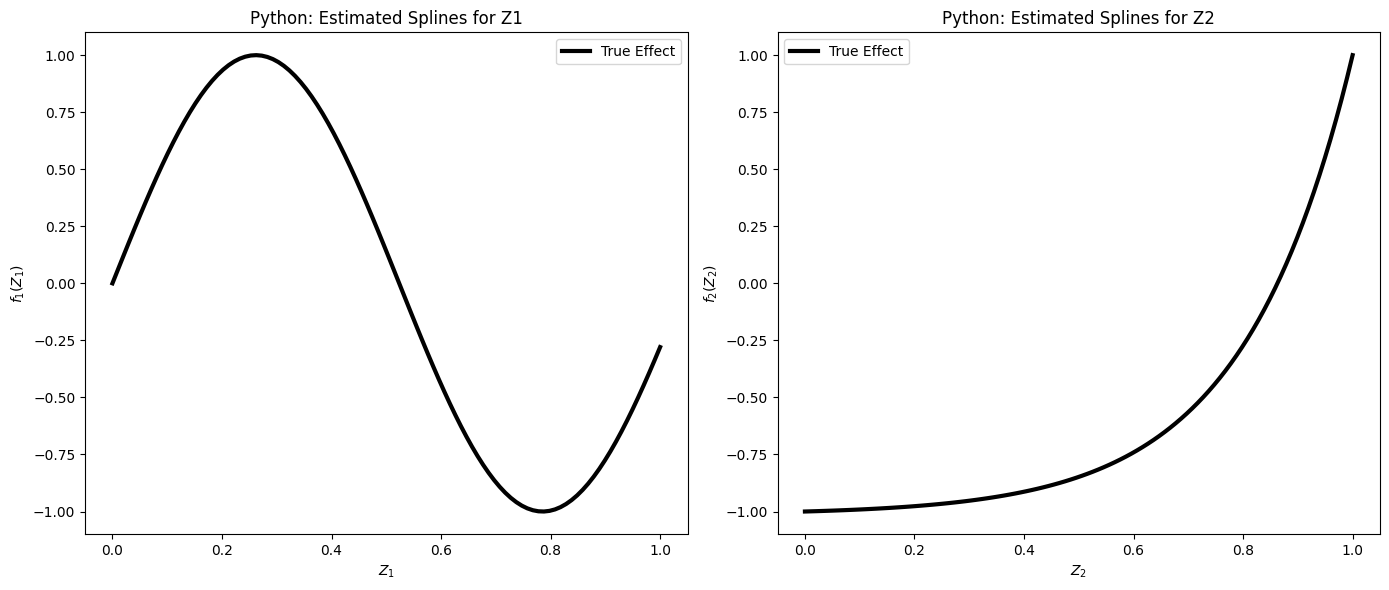

Python-only figure saved as ./outputs_wo_unstructured/python_estimated_splines.png


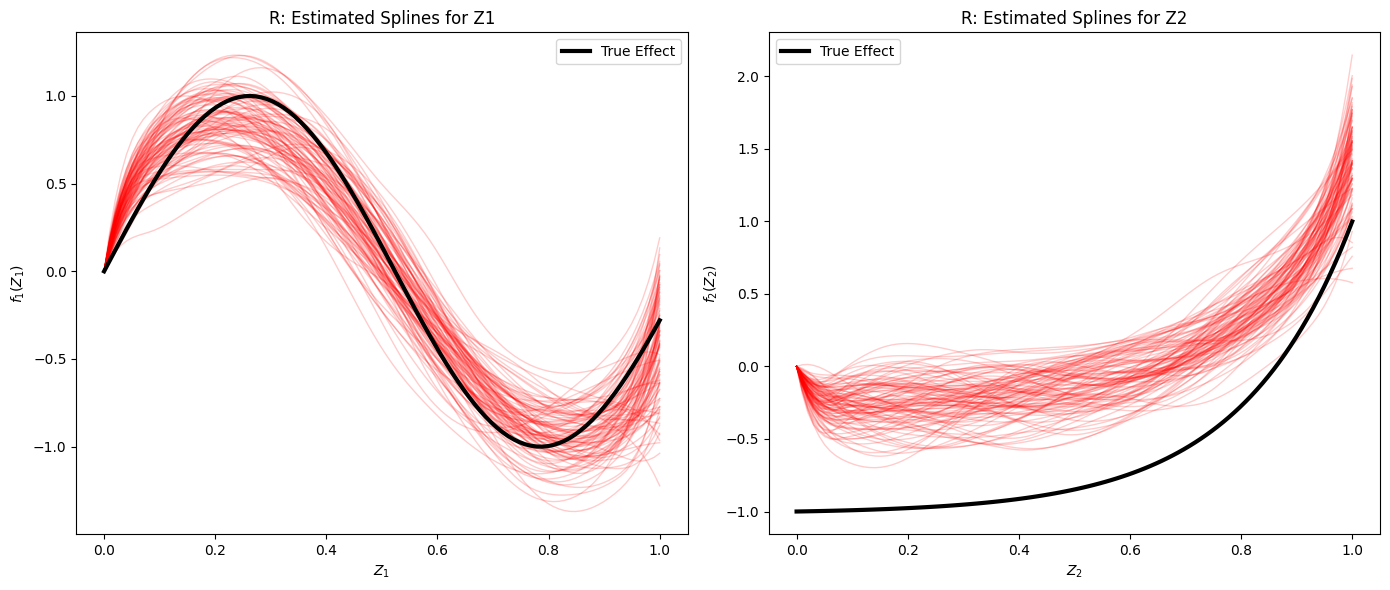

R-only figure saved as ./outputs_wo_unstructured/r_estimated_splines.png


In [6]:
# Parameters (adjust as needed)
n = 1000
n_reps = 100
d = "gaussian_homo"
snr = 8
n_knots = 10   # so that n_knots+4 equals 14
method = "point_estimates"
python_estimate_path = "./outputs_wo_unstructured/"
r_estimate_path = "../../SSDR/results/point_estimates/"
true_path = "../data_generation/output"
true_linear = {'loc': {'Intercept': 0, 'X1': 3, 'X2': -1}}

# Plot combined spline estimates
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=False)



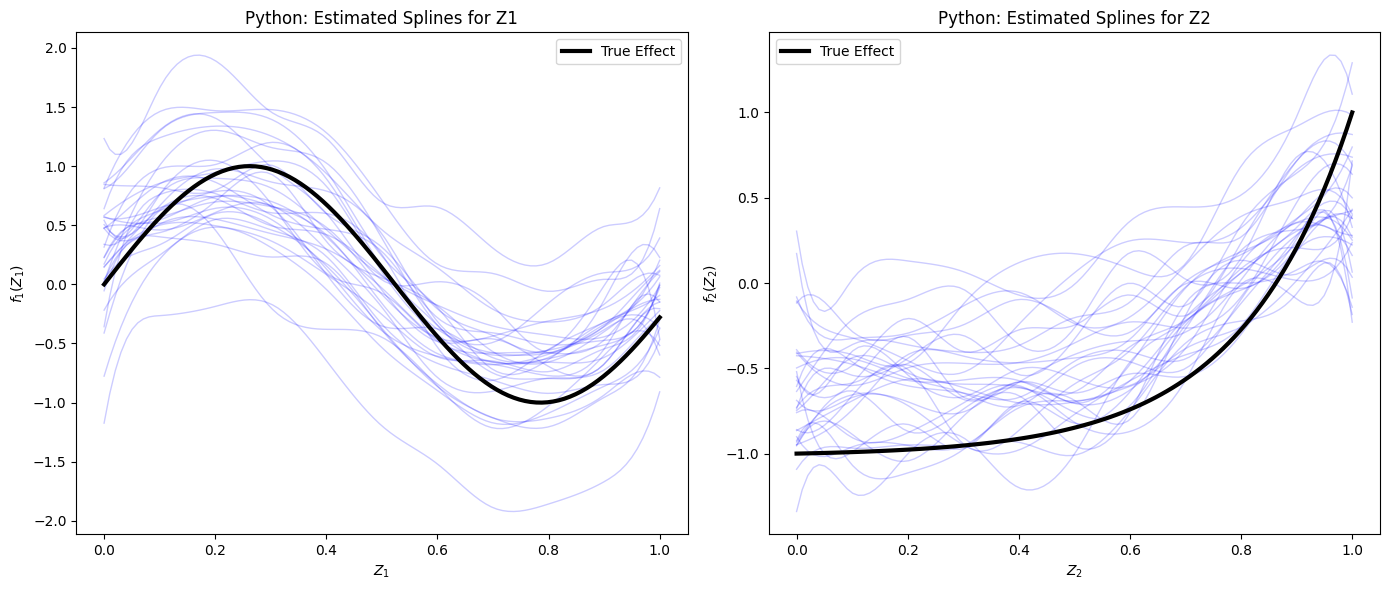

Python-only figure saved as ./outputs/python_estimated_splines.png


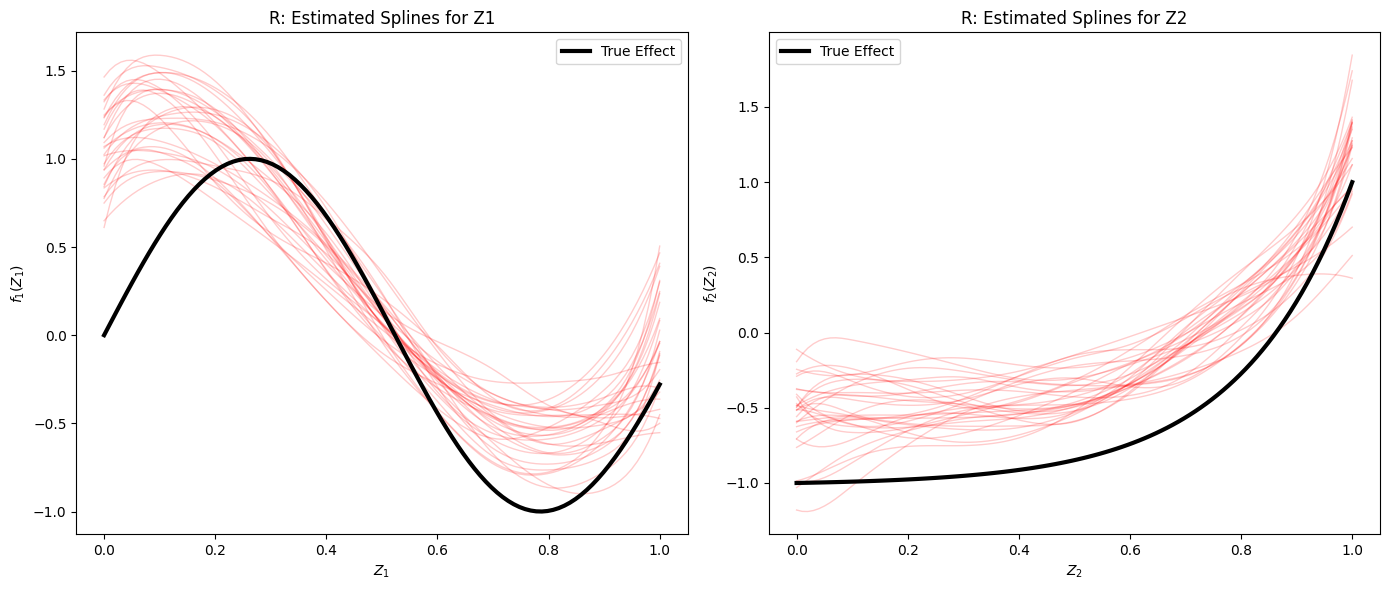

R-only figure saved as ./outputs/r_estimated_splines.png


In [19]:
plot_spline_estimates(n, n_reps, d, snr, n_knots, method,
                      python_estimate_path, r_estimate_path, combined=False, bias_reconstruct=True)

True scale intercept file not found for n_1000_rep_0_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_1_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_2_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_3_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_4_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_5_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_6_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_7_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_8_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_9_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_10_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep_11_dist_gaussian_homo_SNR_1.
True scale intercept file not found for n_1000_rep

/scratch/ipykernel_2269513/659503951.py:162: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(scale_data, patch_artist=True, widths=0.6,


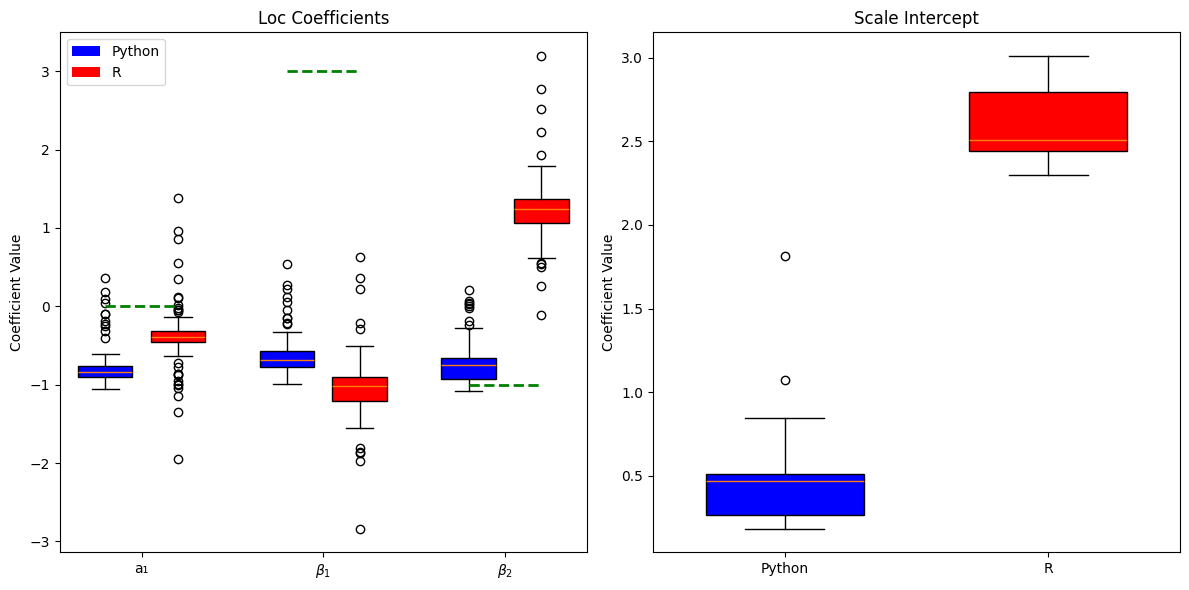

Combined linear boxplot figure saved as ./outputs_wo_unstructured/linear_boxplots_combined.png


In [9]:
# Plot combined linear boxplots
plot_linear_boxplots(n, n_reps, d, snr, method,
                     python_estimate_path, r_estimate_path, true_path, true_linear, combined=True)


In [56]:
import pandas as pd
import re

def parse_value(x):
    """
    Parse a string like "[0.352144]" or "[ 0.39536634 -0.07990031 ... ]" 
    into a float or list of floats.
    """
    # Remove leading and trailing brackets and any extra whitespace
    x = x.strip("[]").strip()
    # Split by whitespace or comma
    parts = re.split("[,\\s]+", x)
    # Remove any empty parts
    parts = [p for p in parts if p != ""]
    if len(parts) == 0:
        return None
    elif len(parts) == 1:
        try:
            return float(parts[0])
        except ValueError:
            return parts[0]
    else:
        try:
            return [float(p) for p in parts]
        except ValueError:
            return parts

# File path to the CSV file produced by R
filename = "../../SSDR/results/point_estimates/point_estimates_n_1000_rep_0_dist_gaussian_homo_SNR_1.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(filename)

# Parse the 'value' column if needed
df['value'] = df['value'].apply(parse_value)

# Option 1: Convert the DataFrame to a dictionary of lists (each column is a key)
coef_dict = df.to_dict(orient="list")

# Option 2: Create a dictionary keyed by scenario_index and param_y, if you prefer a nested structure.
# For example:
nested_coef_dict = {}
for _, row in df.iterrows():
    scenario = row["scenario_index"]
    param_y = row["param_y"]
    param_eta = row["param_eta"]
    value = row["value"]
    if scenario not in nested_coef_dict:
        nested_coef_dict[scenario] = {}
    if param_y not in nested_coef_dict[scenario]:
        nested_coef_dict[scenario][param_y] = {}
    nested_coef_dict[scenario][param_y][param_eta] = value

# Print the dictionaries to check
print("Coefficient dictionary (flat):")
print(coef_dict)
print("\nCoefficient dictionary (nested):")
print(nested_coef_dict)


KeyError: 'value'

In [59]:
import pandas as pd

# Define the scenario_index that was used in the filename.
scenario_index = "n_1000_rep_0_dist_gaussian_homo_SNR_1"

# Construct the file path to the CSV file.
filename = f"../../SSDR/results/point_estimates/point_estimates_{scenario_index}.csv"

# Read the CSV file into a DataFrame.
df = pd.read_csv(filename)

# The CSV from R is in wide format with columns like "X1", "X2", "s.Z1..k...15..bs....cr..", etc.
# Convert (melt) the DataFrame to long format.
df_long = df.melt(var_name="param_eta", value_name="value")

# Add columns for scenario_index and param_y.
# In this example, we assume these coefficients come from the 'loc' model.
df_long["scenario_index"] = scenario_index
df_long["param_y"] = "loc"

# Reorder the columns.
df_long = df_long[["scenario_index", "param_y", "param_eta", "value"]]

# Optionally, convert to a dictionary of lists.
coef_dict = df_long.to_dict(orient="list")

print("Coefficient dictionary:")
print(coef_dict)


Coefficient dictionary:
{'scenario_index': ['n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0_dist_gaussian_homo_SNR_1', 'n_1000_rep_0